## NBA-Playoffs player analysis (2024-25)

This project is an end-to-end ETL and analysis pipeline. The goal is to scrape, store, and analyze NBA player statistics to identify the top offensive player and top defensive player from every team that qualified for the 2024-25 NBA playoffs and visualize the differentials.
The data for this project was: 
1. **`Extracted`** : Scraped from basketball-reference.com, using python scraper curl-cffi and BeautifulSoup
2. **`Transformed`** : Cleaned, parsed and structured to fit into relational schema.
3. **`Loaded`** : Stored in a PostgreSQL DB with a normalized schema.

In [20]:
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
load_dotenv(dotenv_path='../.env')
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")

engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

sns.set_theme(style="whitegrid")

print("Libraries loaded and connection string ready.")

Libraries loaded and connection string ready.


### Initial Data Validation

Before starting the analysis, I'll run a few simple queries to confirm the ETL process worked and that our data is loaded into the tables. First, I'll check the `teams` table for the 16 playoff teams.

In [22]:
sql_query = """
    SELECT * FROM teams
    WHERE is_playoff_team = true;
"""

try:
    playoff_teams_df = pd.read_sql_query(sql_query, engine)
    print("Query successful!")
    
except Exception as e:
    print(f"Error running query: {e}")
display(playoff_teams_df)

Query successful!


,team_id,team_name,team_abbreviation,is_playoff_team
0,1,Cleveland Cavaliers,CLE,True
1,2,Boston Celtics,BOS,True
2,3,New York Knicks,NYK,True
3,4,Indiana Pacers,IND,True
4,5,Milwaukee Bucks,MIL,True
5,6,Detroit Pistons,DET,True
6,7,Orlando Magic,ORL,True
7,8,Miami Heat,MIA,True
8,9,Oklahoma City Thunder,OKC,True
9,10,Houston Rockets,HOU,True


Looks good. The `teams` table is populated. Now, I'll check the `regular_season_stats` table to ensure our player stats were loaded correctly.

In [23]:
sql_query_stats = """
    SELECT * FROM regular_season_stats
    LIMIT 10;
"""
try:
    stats_sample_df = pd.read_sql_query(sql_query_stats, engine)
    print("Query successful!")
    
except Exception as e:
    print(f"Error running query: {e}")

display(stats_sample_df)

Query successful!


,stat_id,player_id,season_year,avg_points,avg_assists,avg_offensive_rebounds,avg_defensive_rebounds,avg_steals,avg_blocks
0,1,9,2024-25,24.0,5.0,0.8,3.7,1.3,0.2
1,2,3,2024-25,20.6,6.7,0.6,2.2,1.2,0.1
2,3,10,2024-25,18.5,3.2,2.3,7.0,0.9,1.6
3,4,1,2024-25,13.5,1.9,2.6,7.1,0.9,0.9
4,5,15,2024-25,9.4,3.2,1.1,3.3,0.5,0.2
5,6,5,2024-25,14.3,1.3,0.6,3.6,0.7,0.3
6,7,7,2024-25,10.2,3.7,0.6,2.2,0.9,0.5
7,8,21,2024-25,5.4,1.3,0.9,3.4,0.7,0.3
8,9,11,2024-25,8.7,1.3,0.7,3.0,0.3,0.1
9,10,6,2024-25,12.5,3.4,0.7,1.8,1.1,0.0


### Simple Analysis: Top 10 League-Wide Scorers

The tables are populated. As a first step, let's ask a simple question: **"Who were the top 10 average scorers in the regular season?"**

To answer this, I'll need to:
1.  **`JOIN`** the `players` table (to get names) with the `regular_season_stats` table (to get points).
2.  **`ORDER BY`** the average points in descending order.
3.  **`LIMIT`** the result to 10.

In [24]:
sql_top_scorers = """
    SELECT p.player_name,s.avg_points
    FROM players p
    JOIN regular_season_stats s ON p.player_id = s.player_id
    WHERE s.season_year = '2024-25'
    ORDER BY s.avg_points DESC
    LIMIT 10;
"""
try:
    top_scorers_df = pd.read_sql_query(sql_top_scorers, engine)
    print("Top 10 scorers query successful!")
    
except Exception as e:
    print(f"Error running query: {e}")

display(top_scorers_df)

Top 10 scorers query successful!


,player_name,avg_points
0,Shai Gilgeous-Alexander,32.7
1,Giannis Antetokounmpo,30.4
2,Nikola Jokić,29.6
3,Luka Dončić,28.2
4,Anthony Edwards,27.6
5,Jayson Tatum,26.8
6,Cade Cunningham,26.1
7,Jalen Brunson,26.0
8,Paolo Banchero,25.9
9,Anthony Davis,25.7


Plotting the results of top 10 scorers

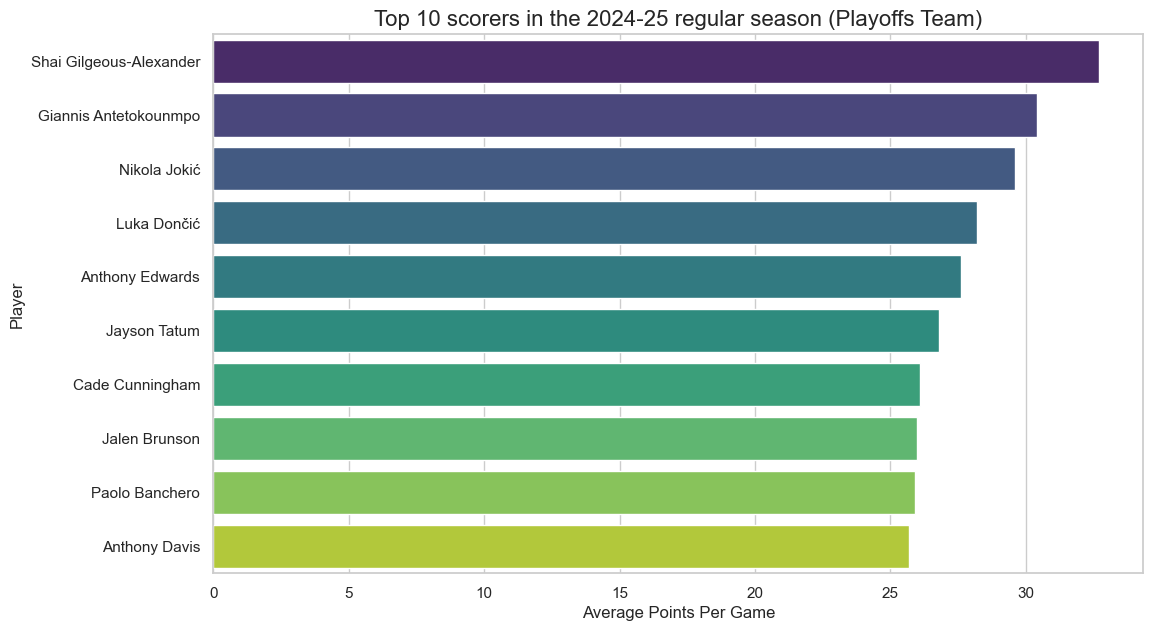

In [28]:
plt.figure(figsize=(12, 7))
sns.barplot(
    data=top_scorers_df,
    x='avg_points',
    y='player_name',
    hue='player_name',
    palette='viridis',
    legend=False
)
plt.title('Top 10 scorers in the 2024-25 regular season (Playoffs Team)', fontsize=16)
plt.xlabel('Average Points Per Game', fontsize=12)
plt.ylabel('Player', fontsize=12)
plt.show()

### Defining a custom "Offensive score" with a Custom Table Expression (CTE)
The top-10 scorer chart is useful, but it does not tell a full story of my project goal. A player's offensive contribution isn't just points. It also includes assists and offensive rebounds.
So to get the actual offensive ratings or scores, I will use a custom formula to calculate offensive score. 

**Formula :** 
`offensive_score = (points * 1.0) + (ssists * 1.5) + (offensive rebounds * 1.2)`

Now I will use **CTE**
1.  The CTE using the `WITH` keyword will first create a temporary table of all playoff players and their calculated scores.
2.  The main query will then select from that temporary table to show the new "Top 10" based on this more complete offensive score.

In [36]:
sql_cte_score = """
WITH player_offensive_scores AS (
    SELECT p.player_name, t.team_name, (rs.avg_points * 1.0 + rs.avg_assists * 1.5 + rs.avg_offensive_rebounds * 1.2) AS offensive_score
    FROM players p
    JOIN teams t ON p.team_id = t.team_id
    JOIN regular_season_stats rs ON p.player_id = rs.player_id
    WHERE t.is_playoff_team = true AND rs.season_year = '2024-25'
)

SELECT * FROM player_offensive_scores
ORDER BY offensive_score DESC
LIMIT 10;
"""

try:
    top_offensive_df = pd.read_sql_query(sql_cte_score, engine)
    print("Top 10 Offensive Players query successful!")
    
except Exception as e:
    print(f"Error running query: {e}")

display(top_offensive_df)

Top 10 Offensive Players query successful!


,player_name,team_name,offensive_score
0,Nikola Jokić,Denver Nuggets,48.380000
1,Shai Gilgeous-Alexander,Oklahoma City Thunder,43.380001
2,Giannis Antetokounmpo,Milwaukee Bucks,42.790000
3,Cade Cunningham,Detroit Pistons,40.710001
4,Luka Dončić,Los Angeles Lakers,40.530001
5,LeBron James,Los Angeles Lakers,37.899999
6,Jalen Brunson,New York Knicks,37.430000
7,James Harden,Los Angeles Clippers,36.689999
8,Jayson Tatum,Boston Celtics,36.639999
9,Damian Lillard,Milwaukee Bucks,36.149999


Plotting this new offensive score results

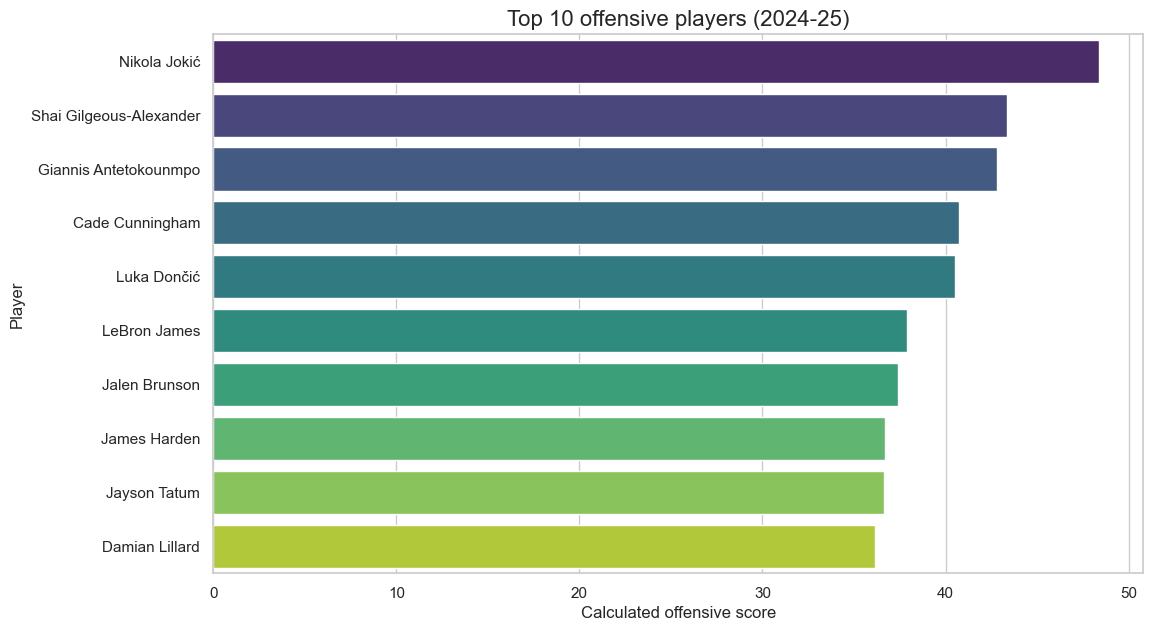

In [35]:
plt.figure(figsize=(12, 7))
sns.barplot(
    data=top_offensive_df,
    x='offensive_score',
    y='player_name',
    hue='player_name',
    palette='viridis',
    legend=False
)
plt.title('Top 10 offensive players (2024-25)', fontsize=16)
plt.xlabel('Calculated offensive score', fontsize=12)
plt.ylabel('Player', fontsize=12)
plt.show()

Similarly, calculating and plotting **Custom defensive score** of the top 10 players from the playoffs team.

**Formula:**
`defensive_score = (steals * 2.0) + (blocks * 1.5) + (defensive rebounds * 0.3)`

In [43]:
sql_cte_defense = """
WITH player_defensive_scores AS (
    SELECT p.player_name, t.team_name, (rs.avg_steals * 2.0 + rs.avg_blocks * 1.5 + rs.avg_defensive_rebounds * 0.3) AS defensive_score
    FROM players p
    JOIN teams t ON p.team_id = t.team_id
    JOIN regular_season_stats rs ON p.player_id = rs.player_id
    WHERE t.is_playoff_team = true AND rs.season_year = '2024-25'
)
SELECT * FROM player_defensive_scores
ORDER BY defensive_score DESC
LIMIT 10;
"""

try:
    top_defensive_df = pd.read_sql_query(sql_cte_defense, engine)
    print("Top 10 defensive players query successful!")
    
except Exception as e:
    print(f"Error running query: {e}")

display(top_defensive_df)

Top 10 defensive players query successful!


,player_name,team_name,defensive_score
0,Anthony Davis,Los Angeles Lakers,8.45
1,Nikola Jokić,Denver Nuggets,7.47
2,Chet Holmgren,Oklahoma City Thunder,6.65
3,Giannis Antetokounmpo,Milwaukee Bucks,6.51
4,Amen Thompson,Houston Rockets,6.37
5,Evan Mobley,Cleveland Cavaliers,6.30
6,Myles Turner,Indiana Pacers,6.19
7,Shai Gilgeous-Alexander,Oklahoma City Thunder,6.13
8,Draymond Green,Golden State Warriors,6.00
9,Karl-Anthony Towns,New York Knicks,5.99


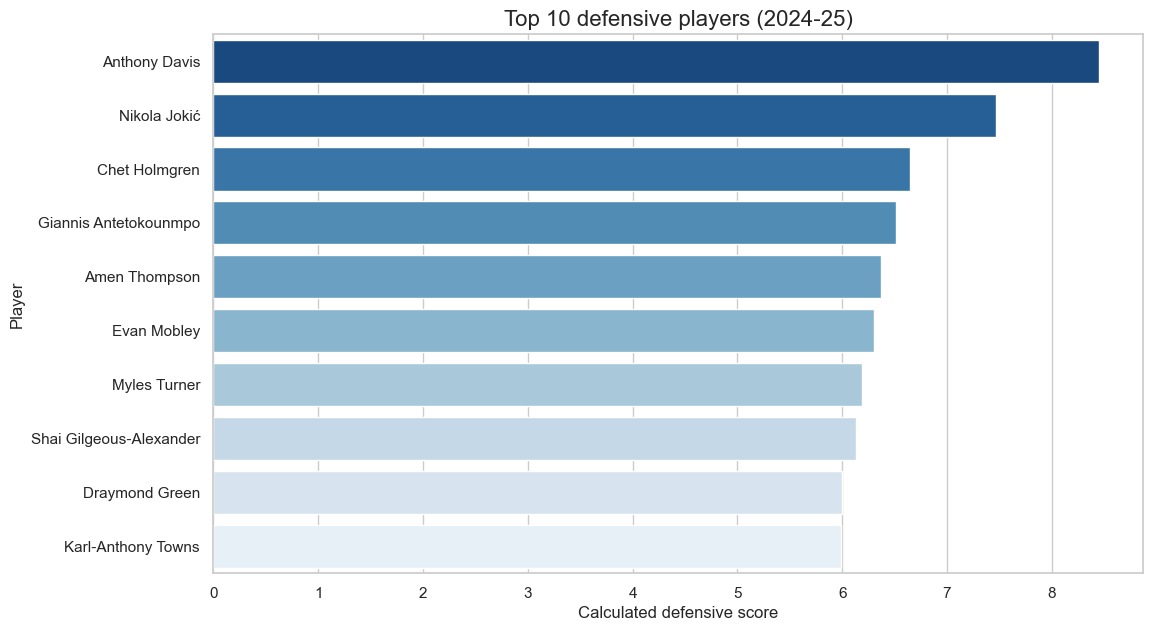

In [44]:
plt.figure(figsize=(12, 7))
sns.barplot(
    data=top_defensive_df,
    x='defensive_score',
    y='player_name',
    hue='player_name',
    palette='Blues_r',
    legend=False  
)
plt.title('Top 10 defensive players (2024-25)', fontsize=16)
plt.xlabel('Calculated defensive score', fontsize=12)
plt.ylabel('Player', fontsize=12)
plt.show()

### Analyzing a single team's offensive profile
Before I build the final query to rank all players on all 16 teams, I want to develop and test my logic on a single team. This will help me validate my offensive formula and create a more detailed visualization.

I will focus on the **Golden State Warriors** (who I know are `team_id = 15` from my earlier `playoff_teams_df`).

What I will do here : 
1.  **Use a CTE:** I'll create a `WITH` clause to calculate the score for players with `team_id = 15`.
2.  **Break Down the Score:** I'll calculate the *components* of the score (`points_score`, `assists_score`, `oreb_score`) so I can use them in a stacked bar chart.
3.  **Filter and Sort:** I'll `ORDER BY` the total score and take the `LIMIT 5`.

In [45]:
sql_gsw_offensive = """
WITH gsw_player_scores AS (
    SELECT p.player_name, (rs.avg_points * 1.0) AS points_contribution, (rs.avg_assists * 1.5) AS assists_contribution, (rs.avg_offensive_rebounds * 1.2) AS oreb_contribution,
        (rs.avg_points * 1.0 + rs.avg_assists * 1.5 + rs.avg_offensive_rebounds * 1.2) AS total_offensive_score
    FROM players p
    JOIN regular_season_stats rs ON p.player_id = rs.player_id
    WHERE p.team_id = 15 -- Filtering for Golden State Warriors AND rs.season_year = '2024-25'
)
SELECT * FROM gsw_player_scores
ORDER BY total_offensive_score DESC
LIMIT 5;
"""

try:
    gsw_top_5_df = pd.read_sql_query(sql_gsw_offensive, engine)
    print("GSW Top 5 offensive players query successful!")
    
except Exception as e:
    print(f"Error running query: {e}")
display(gsw_top_5_df)

GSW Top 5 offensive players query successful!


,player_name,points_contribution,assists_contribution,oreb_contribution,total_offensive_score
0,Stephen Curry,24.5,9.00,0.72,34.220000
1,Jimmy Butler,17.9,8.85,2.76,29.510000
2,Andrew Wiggins,17.6,3.60,1.80,23.000001
3,Jonathan Kuminga,15.3,3.30,1.44,20.040000
4,Draymond Green,9.0,8.40,1.32,18.720000


Visualizing using horizontal stacked bar chart

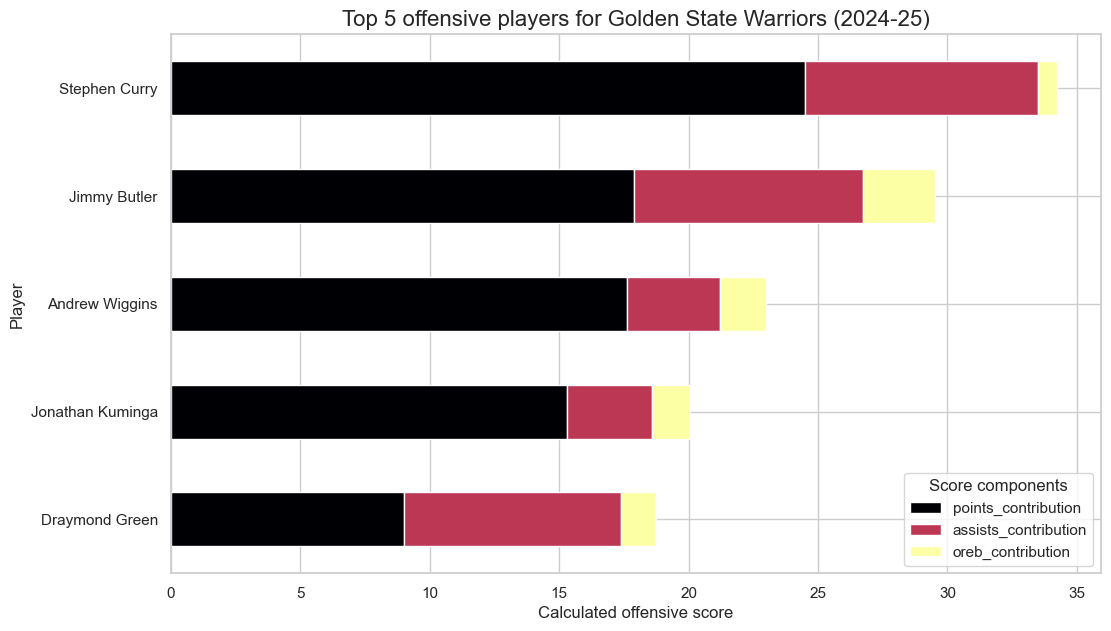

In [49]:
plot_df = gsw_top_5_df.set_index('player_name')
score_components_df = plot_df[['points_contribution', 'assists_contribution', 'oreb_contribution']]
ax = score_components_df.plot(
    kind='barh', 
    stacked=True, 
    figsize=(12, 7),
    colormap='inferno' 
)
ax.set_title('Top 5 offensive players for Golden State Warriors (2024-25)', fontsize=16)
ax.set_xlabel('Calculated offensive score', fontsize=12)
ax.set_ylabel('Player', fontsize=12)
ax.invert_yaxis() 
plt.legend(title='Score components')
plt.show()

### GSW defensive profile 

In [57]:
sql_gsw_defensive = """
WITH gsw_player_defensive_scores AS (
    SELECT p.player_name, (rs.avg_steals * 2.0) AS steals_contribution, (rs.avg_blocks * 1.5) AS blocks_contribution, (rs.avg_defensive_rebounds * 0.3) AS dreb_contribution,
        (rs.avg_steals * 2.0 + rs.avg_blocks * 1.5 + rs.avg_defensive_rebounds * 0.3) AS total_defensive_score
    FROM players p
    JOIN regular_season_stats rs ON p.player_id = rs.player_id
    WHERE p.team_id = 15 -- Filtering for Golden State Warriors AND rs.season_year = '2024-25'
)
SELECT * FROM gsw_player_defensive_scores
ORDER BY total_defensive_score DESC
LIMIT 5;
"""

try:
    gsw_top_5_def_df = pd.read_sql_query(sql_gsw_defensive, engine)
    print("GSW Top 5 defensive players query successful!")

except Exception as e:
    print(f"Error running query: {e}")

display(gsw_top_5_def_df)

GSW Top 5 defensive players query successful!


,player_name,steals_contribution,blocks_contribution,dreb_contribution,total_defensive_score
0,Draymond Green,3.0,1.50,1.50,6.00
1,Jimmy Butler,3.4,0.45,0.96,4.81
2,Stephen Curry,2.2,0.60,1.17,3.97
3,Andrew Wiggins,1.8,1.20,0.90,3.90
4,Brandin Podziemski,2.2,0.30,1.23,3.73


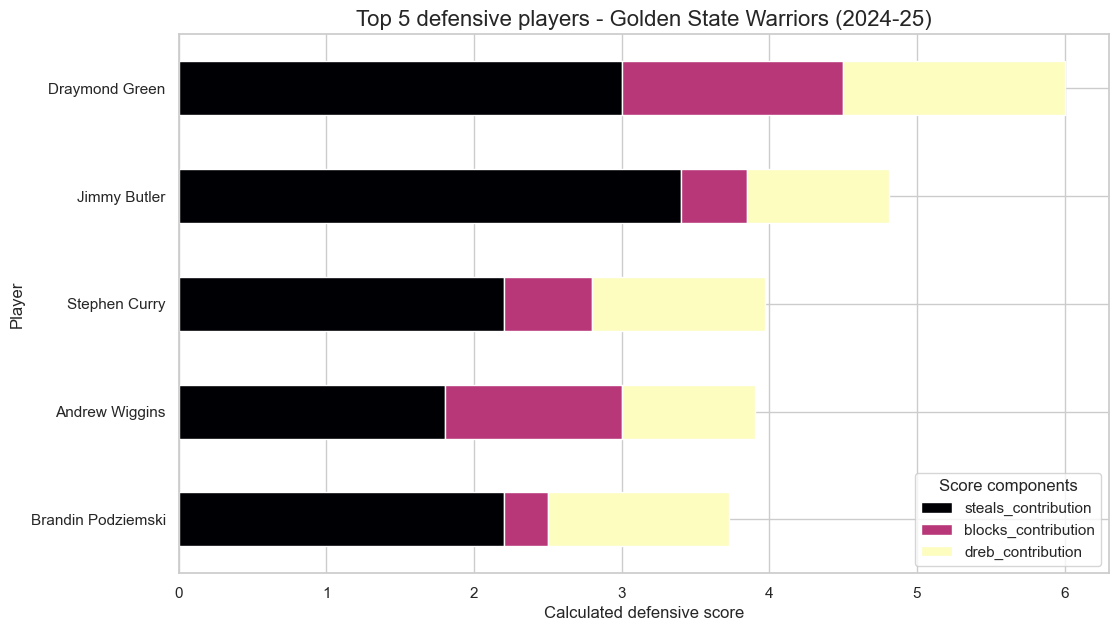

In [82]:
plot_df = gsw_top_5_def_df.set_index('player_name')
score_components_df = plot_df[['steals_contribution', 'blocks_contribution', 'dreb_contribution']]
ax = score_components_df.plot(
    kind='barh',     
    stacked=True,    
    figsize=(12, 7),
    colormap='magma' 
)
ax.set_title('Top 5 defensive players - Golden State Warriors (2024-25)', fontsize=16)
ax.set_xlabel('Calculated defensive score', fontsize=12)
ax.set_ylabel('Player', fontsize=12)
ax.invert_yaxis() 
plt.legend(title='Score components')
plt.show()

### Final Analysis: Top 1 offsensive & top 1 defensive player per team

To provide a clearer, more direct comparison, I will simplify the final output to:
* Identify the **single best offensive player** from each playoff team.
* Identify the **single best defensive player** from each playoff team.

Then, I will create **two distinct charts** to compare these elite players across the entire league. This will allow for a clear, ranked comparison of each team's top contributor in a specific category.
The SQL logic will remain similar, using:
1.  **CTEs (`WITH ... AS`)**: To calculate offensive and defensive scores.
2.  **`JOIN`s**: To gather data from `players`, `teams`, and `regular_season_stats`.
3.  **Window Function (`RANK() OVER ...`)**: To rank players within their own team.
4.  **Filtering (`WHERE`)**: This time, I'll filter for `offensive_rank <= 1` or `defensive_rank <= 1`.

In [76]:
sql_top_1_per_team = """
WITH player_scores AS (
        SELECT p.player_name, t.team_name, (rs.avg_points * 1.0) AS points_contribution, (rs.avg_assists * 1.5) AS assists_contribution, (rs.avg_offensive_rebounds * 1.2) AS oreb_contribution,
        (rs.avg_points * 1.0 + rs.avg_assists * 1.5 + rs.avg_offensive_rebounds * 1.2) AS offensive_score,
        (rs.avg_steals * 2.0) AS steals_contribution, (rs.avg_blocks * 1.5) AS blocks_contribution, (rs.avg_defensive_rebounds * 0.3) AS dreb_contribution,
        (rs.avg_steals * 2.0 + rs.avg_blocks * 1.5 + rs.avg_defensive_rebounds * 1.0) AS defensive_score  
    FROM players p JOIN teams t ON p.team_id = t.team_id
    JOIN regular_season_stats rs ON p.player_id = rs.player_id
    WHERE t.is_playoff_team = true AND rs.season_year = '2024-25'
),
ranked_players AS (
    SELECT *, RANK() OVER(PARTITION BY team_name ORDER BY offensive_score DESC) as offensive_rank, RANK() OVER(PARTITION BY team_name ORDER BY defensive_score DESC) as defensive_rank
    FROM player_scores
)

SELECT * FROM ranked_players
WHERE offensive_rank <= 1 OR defensive_rank <= 1
ORDER BY team_name, offensive_rank;
"""

try:
    final_top_players_df = pd.read_sql_query(sql_top_1_per_team, engine)
    print("Top 1 offensive/defensive players per team query successful!")
    
except Exception as e:
    print(f"Error running query: {e}")

display(final_top_players_df)

Top 1 offensive/defensive players per team query successful!


,player_name,team_name,points_contribution,assists_contribution,oreb_contribution,offensive_score,steals_contribution,blocks_contribution,dreb_contribution,defensive_score,offensive_rank,defensive_rank
0,Jayson Tatum,Boston Celtics,26.799999,9.000000,0.84,36.639999,2.2,0.75,2.40,10.95,1,1
1,Donovan Mitchell,Cleveland Cavaliers,24.000000,7.500000,0.96,32.460000,2.6,0.30,1.11,6.60,1,3
2,Evan Mobley,Cleveland Cavaliers,18.500000,4.800000,2.76,26.060000,1.8,2.40,2.10,11.20,3,1
3,Nikola Jokić,Denver Nuggets,29.600000,15.300000,3.48,48.380000,3.6,0.90,2.97,14.40,1,1
4,Cade Cunningham,Detroit Pistons,26.100000,13.650001,0.96,40.710001,2.0,1.20,1.59,8.50,1,2
5,Jalen Duren,Detroit Pistons,11.800000,4.050000,4.32,20.170000,1.4,1.65,2.04,9.85,3,1
6,Stephen Curry,Golden State Warriors,24.500000,9.000000,0.72,34.220000,2.2,0.60,1.17,6.70,1,3
7,Draymond Green,Golden State Warriors,9.000000,8.400000,1.32,18.720000,3.0,1.50,1.50,9.50,5,1
8,Alperen Şengün,Houston Rockets,19.100000,7.350000,4.08,30.530001,2.2,1.20,2.07,10.30,1,1
9,Tyrese Haliburton,Indiana Pacers,18.600000,13.800000,0.72,33.120000,2.8,1.05,0.90,6.85,1,4


### Comparing Top Players Across the League

With our `final_top_players_df`, we can now create clear visualizations for each category (Offensive and Defensive).

### Top offensive player from each playoff team

This chart will rank all 16 playoff teams' best offensive players by their calculated `offensive_score`.

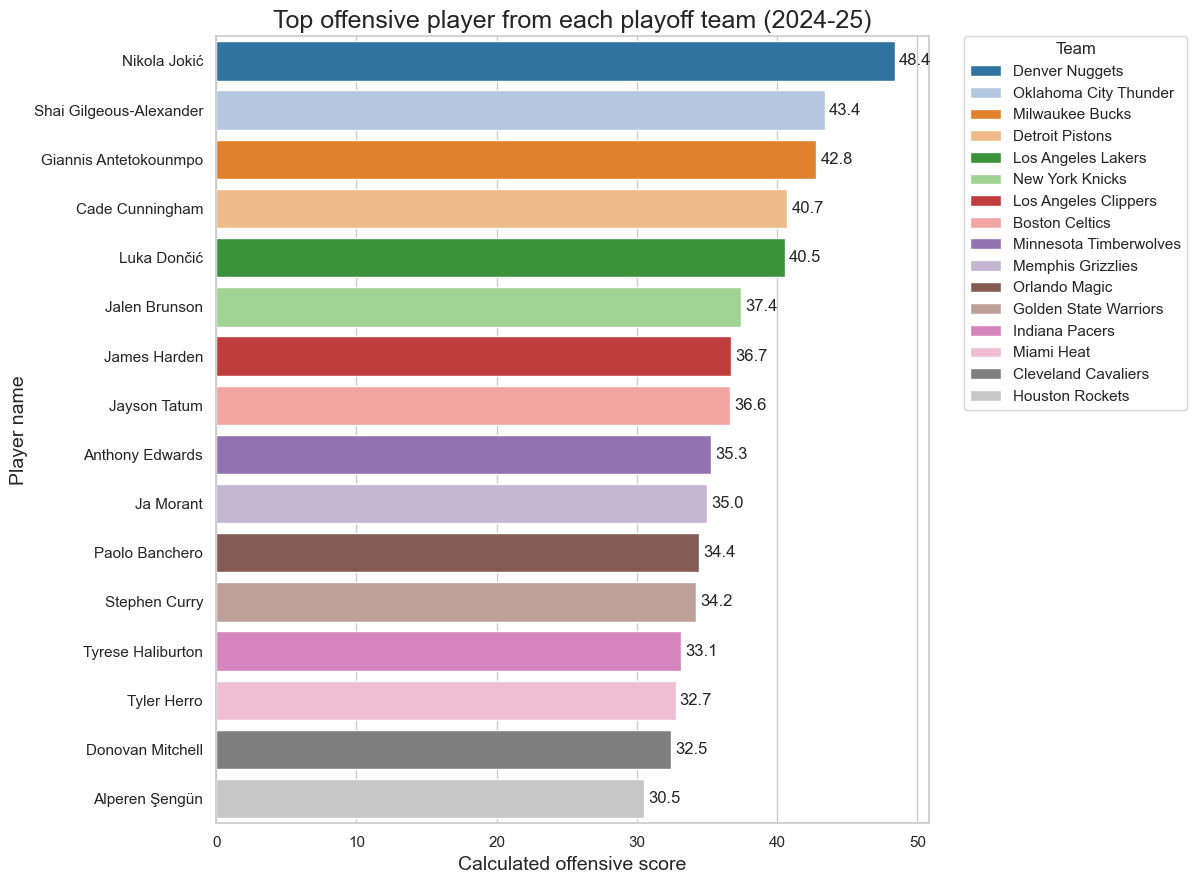

In [83]:
top_offensive_across_league = final_top_players_df[
    final_top_players_df['offensive_rank'] == 1
].sort_values('offensive_score', ascending=False)

plt.figure(figsize=(14, 9))
ax = sns.barplot(
    data=top_offensive_across_league,
    x='offensive_score',
    y='player_name',
    hue='team_name',  
    palette='tab20',  
    dodge=False  
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', label_type='edge', padding=3)

ax.set_title('Top offensive player from each playoff team (2024-25)', fontsize=18)
ax.set_xlabel('Calculated offensive score', fontsize=14)
ax.set_ylabel('Player name', fontsize=14)
ax.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.88, 1]) 
plt.show()

### Top defensive player from each playoff team

This chart will rank all 16 playoff teams' best defensive players by their calculated `defensive_score`.

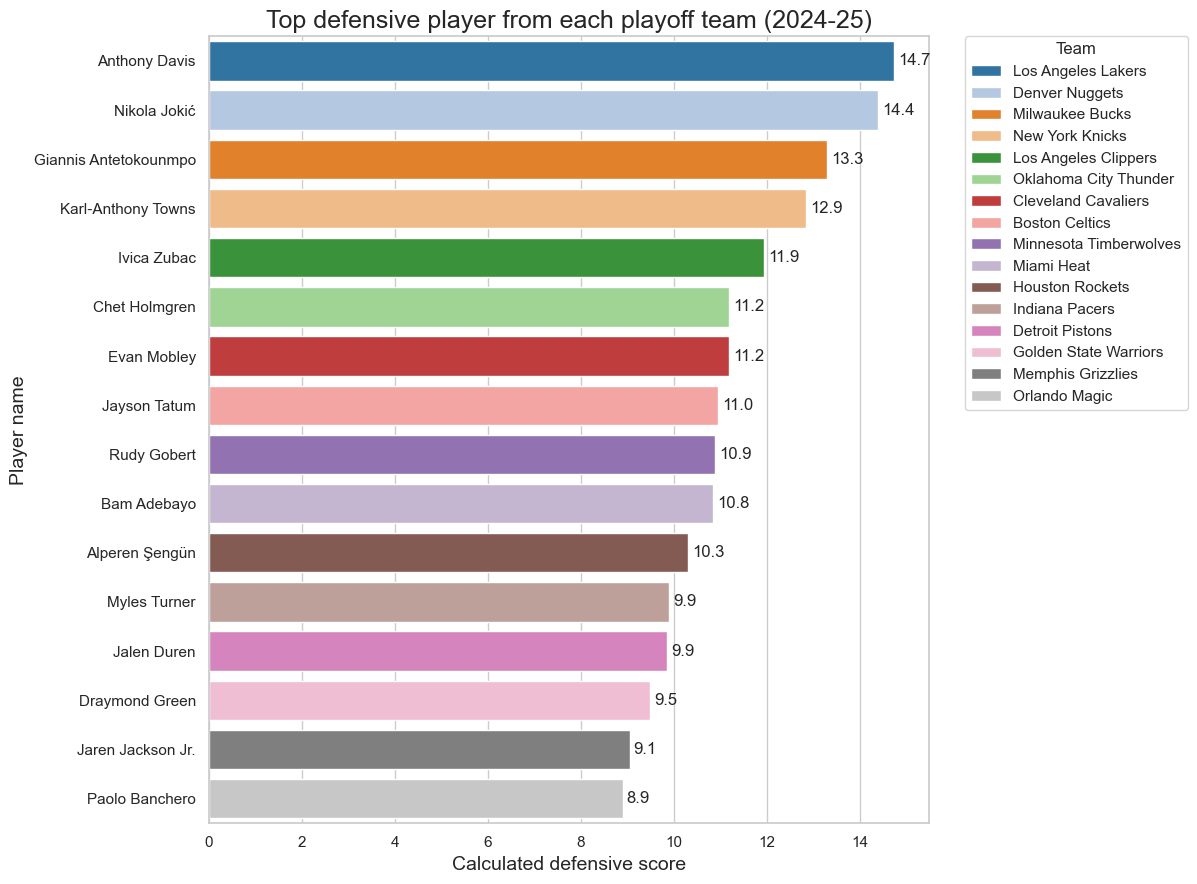

In [84]:
top_defensive_across_league = final_top_players_df[
    final_top_players_df['defensive_rank'] == 1
].sort_values('defensive_score', ascending=False)
plt.figure(figsize=(14, 9))
ax = sns.barplot(
    data=top_defensive_across_league,
    x='defensive_score',
    y='player_name',
    hue='team_name', 
    palette='tab20', 
    dodge=False
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', label_type='edge', padding=3)
ax.set_title('Top defensive player from each playoff team (2024-25)', fontsize=18)
ax.set_xlabel('Calculated defensive score', fontsize=14)
ax.set_ylabel('Player name', fontsize=14)
ax.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.88, 1]) 
plt.show()

### Player role analysis using Scatter plot

The bar charts are good for ranking, but they don't show the relationship between offense and defense. For my final analysis, I want to visualize the "differentials" and see if the top players from each team are **specialists** or **two-way stars**.

A **Scatter Plot** is the perfect tool for this. I will plot every top player from each team on a single chart:
* The **Y-axis** will be their `offensive_score`.
* The **X-axis** will be their `defensive_score`.

This will create four quadrants. Players in the top-right are elite at both (two-way stars), players in the top-left are offensive specialists, players in the bottom-right are defensive sspecialists, and in the bottom-left, players are somewhere in the middle with defense and offense

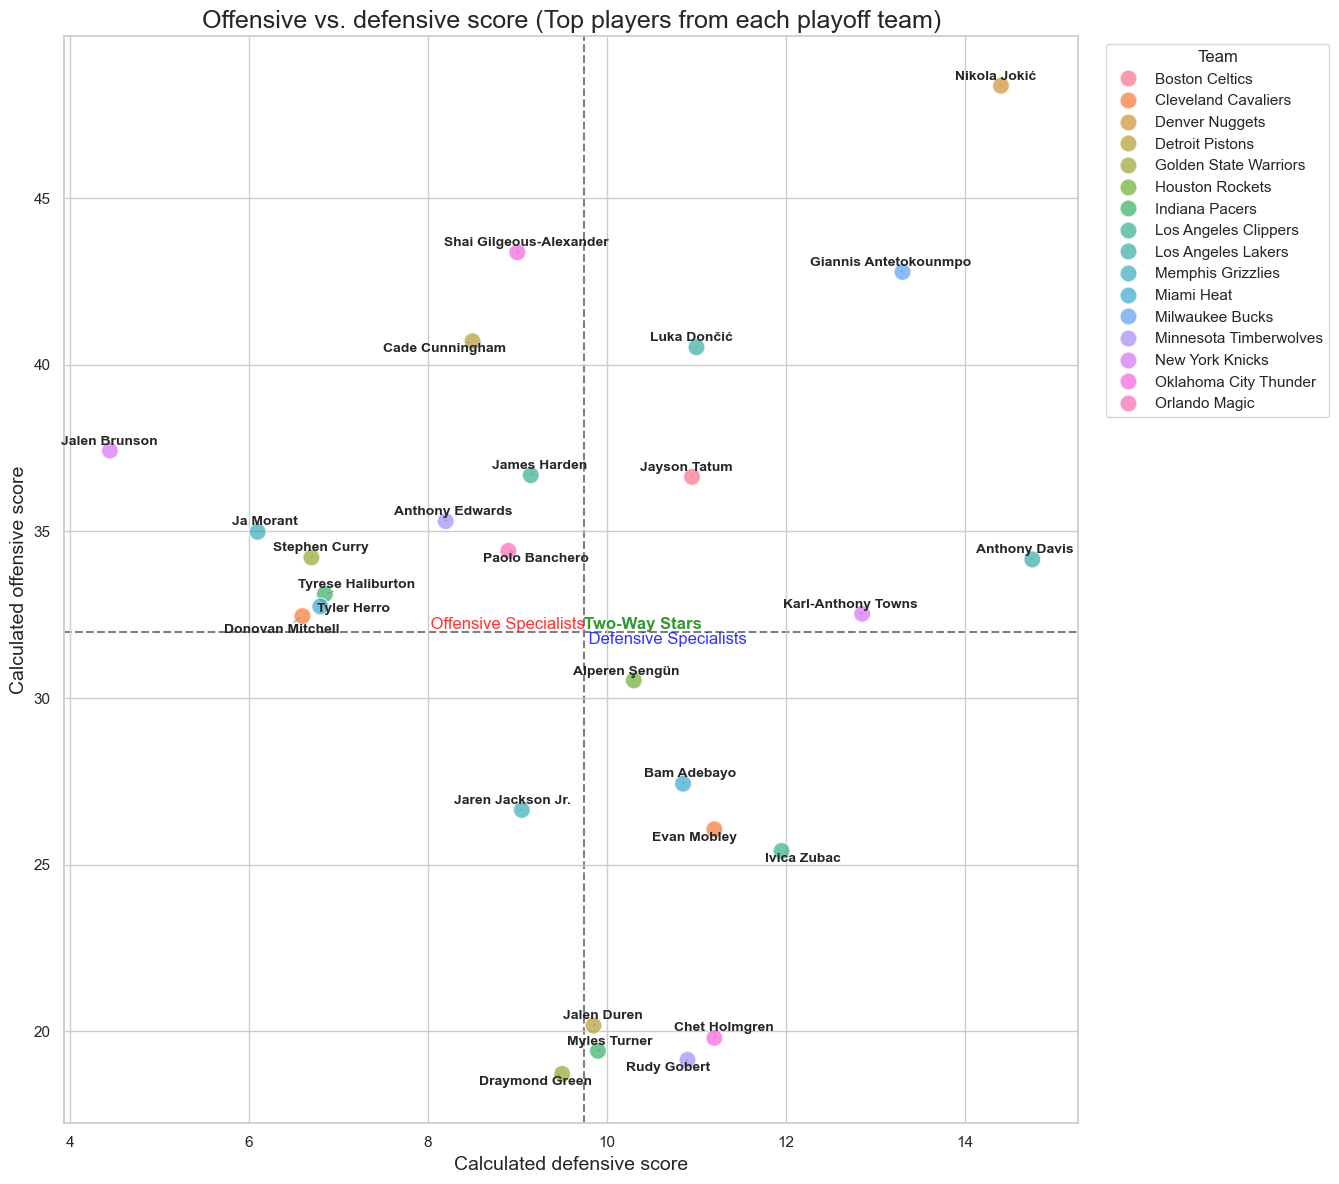

In [93]:
from adjustText import adjust_text
avg_offense = final_top_players_df['offensive_score'].mean()
avg_defense = final_top_players_df['defensive_score'].mean()

plt.figure(figsize=(16, 12))
ax = sns.scatterplot(
    data=final_top_players_df,
    x='defensive_score',
    y='offensive_score',
    hue='team_name',  
    s=150,           
    alpha=0.7,
    legend='full'
)
ax.axvline(avg_defense, ls='--', color='gray', zorder=0)
ax.axhline(avg_offense, ls='--', color='gray', zorder=0)
ax.text(avg_defense, avg_offense, 'Two-Way Stars', 
        fontsize=12, color='green', alpha=0.8, weight='bold', va='bottom', ha='left', transform=ax.transData)
ax.text(avg_defense, avg_offense, ' Offensive Specialists', 
        fontsize=12, color='red', alpha=0.8, ha='right', va='bottom', transform=ax.transData)
ax.text(avg_defense, avg_offense, ' Defensive Specialists\n', 
        fontsize=12, color='blue', alpha=0.8, va='top', ha='left', transform=ax.transData)
texts = []
for i, row in final_top_players_df.iterrows():
    texts.append(
        ax.text(row['defensive_score'], row['offensive_score'], row['player_name'],
                ha='center', size='small', weight='semibold')
    )
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
ax.set_title('Offensive vs. defensive score (Top players from each playoff team)', fontsize=18)
ax.set_xlabel('Calculated defensive score', fontsize=14)
ax.set_ylabel('Calculated offensive score', fontsize=14)
ax.legend(title='Team', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.show()

### Conclusion
This project successfully built an end-to-end ETL (Extract, Transform, Load) pipeline to analyze NBA playoff-team players performance.
1. Extracted (E): Scraped basketball-reference.com using curl_cffi and BeautifulSoup.
2. Transformed (T): Cleaned the raw HTML and structured it into a normalized relational model.
3. Loaded (L): Stored all team, player, and statistical data in a PostgreSQL database.

The analysis used intermediate SQL, including CTEs and Window Functions (RANK() OVER ...), to calculate custom "Offensive" and "Defensive" scores. With its help, the players ranking were eastablished within their own team rather than league-wide.
The final visualizations successfully identified the top offensive and defensive player from each team, and the scatter plot categorized these top players into "Two-Way Stars," "Offensive Specialists," and "Defensive Specialists," achieving the project's goal of visualizing their performance differentials.